# **Assignment 2**
# Implementing Bahdanau Attention Mechanism in Machine Translation

## Objective


Understand and implement the Bahdanau Attention Mechanism for sequence-to-sequence learning. Try out different changes to the implementation and understand changes.

# Instructions



The assignment includes two parts, the first is filling in the missing code in the provided code cells. The second part deals with testing and comparing different implementations.

### Submission Guidelines:
*   Assignments are done in pairs, include both ids in the filename when submitting (e.g. *HW02_123456789_123456789.ipynb*).
*   Submit a Jupyter notebook containing your code modifications, comments, and analysis.
*   Include visualizations, graphs, or plots to support your analysis where needed.
*   Provide a conclusion summarizing your findings, challenges faced, and potential future improvements.


### Important Notes:

*  Ensure clarity in code comments and explanations for better understanding.
*  Experiment, analyze, and document your observations throughout the assignment.
*  Feel free to train on GPU (see example in practice 4 notebook).
*  If answering open ended questions in Markdown is difficult, you can attatch a doc/pdf file to your submittion which holds any/all explanations. Just make sure it is aligned with the code somehow.
*  Feel free to seek clarification on any aspect of the assignment via email.

# Part 1 - The Bahdanau Attention Mechanism

Review the provided implementation of the Bahdanau (or Additive) Attention Mechanism in a Seq2Seq model for translation. Note that in some parts of the code, methods from the `d2l` library are used. Explanations are provided wherever such methods are used.

There are parts of the implementation that you need to complete. Please read the instructions carefully and fill in the missing lines of code as required.

In [ ]:
!pip install numpy>=1.24.1 pandas==1.5.3
!pip install -q d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 r

In [ ]:
# import needed libraries

import torch
from torch import nn
from d2l import torch as d2l

### Motivation

When we encountered machine translation we designed an encoder--decoder architecture for sequence-to-sequence learning based on two RNNs. In an RNN all relevant information about a source sequence is translated into some internal *fixed-dimensional* state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

While this is quite reasonable for short sequences, it is clear that it is infeasible for long ones, such as a book chapter or even just a very long sentence. After all, before too long there will simply not be enough "space" in the intermediate representation to store all that is important in the source sequence. Consequently the decoder will fail to translate long and complex sentences.

Bahdanau proposed a differentiable attention model
in it, if not all the input tokens are relevant,
the model aligns (or attends) only to parts of the input sequence that are deemed relevant to the current prediction. This is then used to update the current state before generating the next token. The encoder-decoder architecture using attention is presented here:

<br>

<center><img src="https://d2l.ai/_images/seq2seq-details-attention.svg" width="600" /></center>

<br>


#### The model

The key idea is that instead of keeping the state,
i.e., the context variable $\mathbf{c}$ summarizing the source sentence, as fixed, we dynamically update it, as a function of both the original text (encoder hidden states $\mathbf{h}_{t}$) and the text that was already generated (decoder hidden states $\mathbf{s}_{t'-1}$). This yields $\mathbf{c}_{t'}$, which is updated after any decoding time step $t'$. Suppose that the input sequence is of length $T$. In this case the context variable is the output of:

$$\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_{t}) \mathbf{h}_{t}.$$

$\mathbf{s}_{t' - 1}$ is the query, and
$\mathbf{h}_{t}$ is both the key and the value. Note that $\mathbf{c}_{t'}$ is then used to generate the state $\mathbf{s}_{t'}$ and to generate a new token. $\alpha$ is the attention weight calculated using the additive attention scoring function.



### Masked Softmax



In cases where sequences of different lengths are in the same minibatch, padding with dummy tokens is necessary. However, these tokens should not be included in the attention model. This common problem is addressed with the masked softmax operation, which effectively ignores the contribution of these dummy tokens.

(in short we first apply a mask to our data, and then softmax)

In [ ]:
# softmax function - to be used in the attention class in order to "ignore" added tokens (e.g. padding)

def masked_softmax(X, valid_lens):
  """Perform softmax operation by masking elements on the last axis."""
  # X: 3D tensor, valid_lens: 1D or 2D tensor
  def _sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                      device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)
  else:
    shape = X.shape
    if valid_lens.dim() == 1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
      valid_lens = valid_lens.reshape(-1)
    # On the last axis, replace masked elements with a very large negative
    # value, whose exponentiation outputs 0
    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

### Additive Attention implementation



Given a query $\mathbf{q} \in \mathbb{R}^q$
and a key $\mathbf{k} \in \mathbb{R}^k$,
the [*additive attention* scoring function](https://arxiv.org/abs/1409.0473) is given by

<br>
$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
<br>

where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$,
and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization.

An equivalent interpretation it is that the query and key are concatenated and fed into an MLP with a single hidden layer. Using $\tanh$ as the activation function and disabling bias terms.

<br>

---
> **Task 1.1** implement the `MyAdditiveAttention` class accordingly. <br>
(1) Complete the missing initializations in the constructor. <br>(2) In the `forward` method: calculate the queries and keys, and add the missing activation function.

---



In [ ]:
# Additive Attention implementation

class MyAdditiveAttention(nn.Module):
  """Additive attention."""
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(MyAdditiveAttention , self).__init__(**kwargs)
    self.W_k = nn.Linear(num_hiddens, num_hiddens)
    self.W_q = nn.Linear(num_hiddens, num_hiddens)
    self.w_v = nn.Linear(num_hiddens, 1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries = self.W_q(queries)
    keys = self.W_k(keys)
    features = torch.tanh(queries.unsqueeze(2) + keys.unsqueeze(1)) #sum the tensors.

    # There is only one output of self.w_v, so we remove the last
    # one-dimensional entry from the shape.
    scores = self.w_v(features).squeeze(-1)

    self.attention_weights = masked_softmax(scores, valid_lens)

    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # apply batched matrix multi (bmm) with dropout on attention.
    out = torch.bmm(self.dropout(self.attention_weights), values)

    return out

### Encoder

Now we will define the encoder part of our archtecture. The encoder revieves the following parameters as input:

following parameters:
- `vocab_size`: Size of the vocabulary, i.e., the number of unique tokens.
- `embed_size`: Dimensionality of the word embeddings.
- `num_hiddens`: Number of hidden units in the GRU layers.
- `num_layers`: Number of GRU layers.
- `dropout`: Dropout probability (default is 0, meaning no dropout) for the GRU layers.

<br>

---
> **Task 1.2**: Complete the `Seq2SeqEncoder` class by implementing the init and forward methods. The class should include an embedding layer, and afterwards a GRU (layer/s - depending on num_layers).
---

<br>

The `d2l.init_seq2seq` function provides an initialization of the weights of linear and GRU layers in a sequence-to-sequence model using Xavier initialization, which helps in stabilizing the training process and improving convergence.

In [ ]:
# define the encoder

class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
              dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.GRU(input_size=embed_size, hidden_size=num_hiddens,
                      num_layers=num_layers, dropout=dropout)
    # initialize weights for seq2seq learning
    self.apply(d2l.init_seq2seq)

  def forward(self, X, *args):
    embeddings = self.dropout(self.embedding(X).permute(1, 0, 2))
    out, state = self.rnn(embeddings)
    return out, state

### Decoder

The following `Seq2SeqAttentionDecoder` represents the decoder component of the seq2seq model with attention mechanism. It is responsible for decoding the input sequence while attending to the encoder outputs.

<br>

---
> **Task 1.3** Complete the `Seq2SeqAttentionDecoder` class by adding the missing layer initializations in the constructor.
---

In [ ]:
# define the decoder

class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoder, self).__init__()
    self.attention = MyAdditiveAttention(num_hiddens, dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(input_size=embed_size+num_hiddens,
                      hidden_size=num_hiddens, num_layers=num_layers,
                      dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

---
> **Task 1.4** Explain the implemented `forward` method of the `Seq2SeqAttentionDecoder`.
---

> **Task 1.4 Answer**


In the forward step we are getting as the input, the encoder output and a target vector.

Outputs of the encoder:

enc_outputs: (batch_size, num_steps, num_hiddens).
hidden_state: (num_layers, batch_size, num_hiddens)

We are applying the embedding layer on the target shape and reshaping the output to get from (batch_size, num_steps, vocab_size) to (num_steps, batch_size, embed_size).

Now, we want to loop over the indivdual time steps, for each of the steps of X as the **query**, we are taking the **last hidden state**, represents the semantics we encoded up until now, for the first time step it is the encoder's hidden state of the last layer with a representation of the source sentence, and for each of the following steps it is the hidden state of the the decoder represents what was processed up until now.
We are taking the query and for the **keys and values** we are taking **enc_outputs**, as we want to "ask" with the state we got to up until now, what in the source should we attend next and the output attention layer should return the context.
We take the context together with our current time step concatenated, and plug it as input to our rnn, and also the last hidden state as the input hidden state to the rnn.

We get a new hidden state and an output vector with hidden dim, we store all the time steps outpus in a list and at the end, project them back in to our vocab size to get a representation of out words in the translated sentence.

### Test implementation

In the following code snippet, we test the implemented decoder with attention using a minibatch of four sequences, each of which are seven time steps long.

If the `check_shape` test fails an error will be printed, otherwise nothing will happen :)

In [ ]:
# test the implemented decoder with attention using a minibatch of
#four sequences, each of which are seven time steps long.

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)

state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

'''
check the shape of the tensor using the check_shape function,
which takes a tensor and expected shape, returns True if shape is similar,
False otherwise.
'''
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

### Hyperparameters & Data loading

Now that the encoder and decoder parts are ready we can proceed to training: specifying hyperparameters, instantiate an encoder and a decoder with attention, and train this model for machine translation.

<br>

---
> **Task 1.5** Set model hyperparameters.
---


In [ ]:
embed_size = 128 #256
num_hiddens = 256 #512
num_layers = 1
dropout = 0.1
learning_rate = 1e-3

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


We will use a predefined method `MTFraEng` from d2l which takes the batch_size and loads the English-French dataset. The implemented method
- Downloads a txt file and saves it in `./data/fra-eng/fra.txt`
- Preprocesses the setences: lower case, adds/removes spaces where needed.
- Tokenization, splits sentences by tab charachters and appens <eos> tokens for each setence. results in source-target pairs.
- Array building, builds arrays from the tokenized sentences, converting words to indices using vocabularies and padding/truncating sequences to a fixed length. It also constructs vocabularies if not provided.

The method parameters:
1. `batch_size`.
2. `num_steps` (default=9) - specifies the sequence length. Anything longer will be cut, shorter will be padded with "<pad\>".
3. `num_train` (default=512).
4. `num_eval` (default=128).

In [ ]:
data = d2l.MTFraEng(batch_size=batch_size)

The `data` object contains the preprocessed data in the form of tensors. Each source-target setence is represeted using four tensors:

- Source Sequence: Represents the input source sequence. Each element in this array corresponds to a token in the source sequence.
- Target Sequence Input: Represents the input to the decoder (target sequence) during training. This sequence is left-shifted compared to the original target sequence. It excludes the <bos> token and includes the <eos> token.
- Source Sequence Length:
 Represents the lengths of the source sequences. Each element in this array indicates the length of the corresponding source sequence. It is often used to mask padding tokens during computation.
- Target Sequence Output: Represents the expected output from the decoder (target sequence) during training. This sequence is the same as the original target sequence without any modifications. It includes the <bos> token and excludes the <eos> token.

Lets take a look at a sample.

In [ ]:
# @title View data sample

arrays = data.arrays

# Select a sample from the arrays
sample_idx = 2 # @param {type:"integer"}
sample = {
    'source_sequence': arrays[0][sample_idx],  # Source sequence
    'target_sequence_input': arrays[1][sample_idx],  # Target sequence input
    'source_sequence_length': arrays[2][sample_idx],  # Source sequence length
    'target_sequence_output': arrays[3][sample_idx]  # Target sequence output
}

# Print the sample
print("Sample Source Sequence:", sample['source_sequence'])
print("Sample Target Sequence Input:", sample['target_sequence_input'])
print("Sample Source Sequence Length:", sample['source_sequence_length'])
print("Sample Target Sequence Output:", sample['target_sequence_output'])

Sample Source Sequence: tensor([135,   0,   3,   4,   4,   4,   4,   4,   4])
Sample Target Sequence Input: tensor([ 3, 55,  0,  4,  5,  5,  5,  5,  5])
Sample Source Sequence Length: tensor(3)
Sample Target Sequence Output: tensor([55,  0,  4,  5,  5,  5,  5,  5,  5])


Additionally we can view the resulting vocabulary size using:


In [ ]:
print("Source voc size: ", len(data.src_vocab))
print("Target voc size: ", len(data.tgt_vocab))

Source voc size:  194
Target voc size:  214


### Training

First, we will create instances of the encoder and decoder with the required parameters. Next, we will use a prebuilt `Seq2Seq` class and a `Trainer` from the d2l library. These will encapsulate both the encoder and decoder, allowing us to train the final model with the loaded data.

The Seq2Seq class, along with additional methods, enables us to create compelling visualizations during the training process. This is part of the class code.



```
class Seq2Seq(d2l.EncoderDecoder):
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]
      
    ...
```



<br>



---
>**Task 1.6** Fill in the missing parameters in creation of encoder and decoder instances, and in the trainer instance.
---

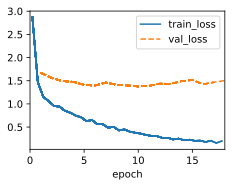

In [ ]:
# train the model using a prebuilt trainer function in d2l
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens,
                         num_layers, dropout)

decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size,
                                  num_hiddens, num_layers, dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)
model.to(device)
#setup trainer function
trainer = d2l.Trainer(max_epochs=18, gradient_clip_val=1.0, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data

We cut the training after 18 epochs, where we are starting to see convergence while trying to avoid large overfitting.
We tried diffrent parmas, lower dimensions (hidden and embedding) to try dealing with what seems like overfitting and no real improvement in the validation but it didn't help. We kept the best hyper params.

### Test a sample

After the model is trained, we use it to translate a few English sentences into French and compute their BLEU scores

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'suis', 'calme', '.'], bleu,0.537
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


We are getting good results on the test samples, the training seems a bit overfitted, We tried lowering the number of params by reducing the embedding and hidden size and number of layers, as well as cutting the training a bit earlier but it didn't really help and the test samples were not as good.

In [ ]:
#Part 1 Experiments log

# embed_size = 256 #256
# num_hiddens = 256 #512
# num_layers = 1
# dropout = 0.1
# learning_rate = 1e-3

# batch_size = 32

# go . => ['va', '!'], bleu,1.000
# i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
# he's calm . => ['je', 'suis', 'calme', '.'], bleu,0.537
# i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000

# embed_size = 256 #256
# num_hiddens = 256 #512
# num_layers = 1
# dropout = 0.3
# learning_rate = 1e-3

# batch_size = 32

# go . => ['va', '!'], bleu,1.000
# i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
# he's calm . => ['<unk>', '.'], bleu,0.000
# i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000

# embed_size = 128 #256
# num_hiddens = 256 #512
# num_layers = 1
# dropout = 0.1
# learning_rate = 1e-3

# batch_size = 32

# go . => ['va', '!'], bleu,1.000
# i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
# he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
# i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000

### Visualize Attention

Let’s visualize the attention weights when translating the last English sentence.

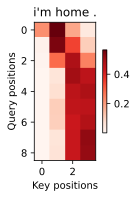

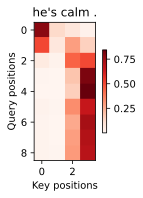

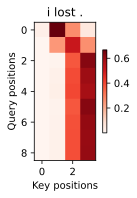

In [ ]:
for i in range(1, 4):
# predict on sample [-1] (last sample)
  _, dec_attention_weights = model.predict_step(
      data.build([engs[-i]], [fras[-i]]), d2l.try_gpu(), data.num_steps, True)
  attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
  attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))
  # Plus one to include the end-of-sequence token

  d2l.show_heatmaps(
      attention_weights[:, :, :, :len(engs[-i].split()) + 1].cpu(),
      xlabel='Key positions', ylabel='Query positions', titles=[engs[-i]])


---
> **Task 1.7** Discuss the resulting visualization, you can run it a few times to have a wider overview.

---



We can see we have 9X4 matrices with the target's focus for each token on the source sentence. we can see that the first tokens get the importance at the begining and words like "calm", "home" and "lost" are important all across the sequence, because they are the most meaningfull token in the sentence. The period get the importance at the end, from the point where we may have to end the translation and on.

# Part 2

In the following part you need to experiment with different changes to the current model and discuss the outcomes. You can use any previosly implemented classes/methods and only write the changed classes here.


> **Task 2.1** Add additional layer/s to the current setup, how do the additional layers affect the training efficiency?

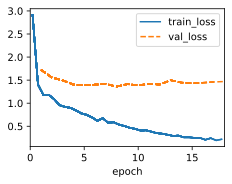

In [ ]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
              dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.GRU(input_size=embed_size, hidden_size=num_hiddens,
                      num_layers=num_layers, dropout=dropout)
    # initialize weights for seq2seq learning
    self.apply(d2l.init_seq2seq)

  def forward(self, X, *args):
    embeddings = self.dropout(self.embedding(X).permute(1, 0, 2))
    out, state = self.rnn(embeddings)
    return out, state

class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoder, self).__init__()
    self.attention = MyAdditiveAttention(num_hiddens, dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(input_size=embed_size+num_hiddens,
                      hidden_size=num_hiddens, num_layers=num_layers,
                      dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)



embed_size = 128 #256
num_hiddens = 256 #512
num_layers = 2
dropout = 0.1
learning_rate = 1e-3

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = d2l.MTFraEng(batch_size=batch_size)

encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens,
                         num_layers, dropout)

decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size,
                                  num_hiddens, num_layers, dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)
model.to(device)
#setup trainer function
trainer = d2l.Trainer(max_epochs=18, gradient_clip_val=1.0, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data

There wasn't any major change after adding a layer. The validation loss is still around 1.5 and the training curve seems similar.
It seems we are overfitting, so adding a layer makes the model more complicated and more tailored around the training set, so we would better off trying to lower the number of params (we tried lowering hidden dim and embedding dim but it didn't help much)

> **Task 2.2** Replace GRU with LSTM in the experiment.

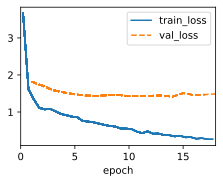

In [ ]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
              dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.LSTM(input_size=embed_size, hidden_size=num_hiddens,
                      num_layers=num_layers, dropout=dropout)
    # initialize weights for seq2seq learning
    self.apply(d2l.init_seq2seq)

  def forward(self, X, *args):
    embeddings = self.dropout(self.embedding(X).permute(1, 0, 2))
    output, (hidden_state, cell_state) = self.rnn(embeddings)
    return output,(hidden_state, cell_state)

class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoder, self).__init__()
    self.attention = MyAdditiveAttention(num_hiddens, dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.LSTM(input_size=embed_size+num_hiddens,
                      hidden_size=num_hiddens, num_layers=num_layers,
                      dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    enc_outputs, (hidden_state, cell_state), enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, (hidden_state, cell_state) = self.rnn(x.permute(1, 0, 2),
       (hidden_state, cell_state))
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, (hidden_state, cell_state),
                                      enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)



embed_size = 128 #256
num_hiddens = 256 #512
num_layers = 1
dropout = 0.1
learning_rate = 1e-3

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = d2l.MTFraEng(batch_size=batch_size)

encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens,
                         num_layers, dropout)

decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size,
                                  num_hiddens, num_layers, dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)
model.to(device)
#setup trainer function
trainer = d2l.Trainer(max_epochs=18, gradient_clip_val=1.0, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data

The main change we can see is that the curves are closer now, making it seem like it is less overfitted (which is counter intuitive because we have more params now), but the validation loss is around the same values so there is no better genralization here.

> **Task 2.3** Modify the experiment to replace the additive attention scoring function with the scaled dot-product. How does it influence the training efficiency?

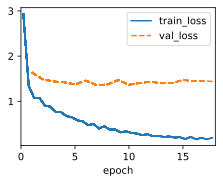

In [ ]:
class Attention(nn.Module):
  """scaled dot product attention."""
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(Attention , self).__init__(**kwargs)
    self.W_k = nn.Linear(num_hiddens, num_hiddens)
    self.W_q = nn.Linear(num_hiddens, num_hiddens)
    self.w_v = nn.Linear(num_hiddens, num_hiddens)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    # apply linear layers
    queries = self.W_q(queries)
    keys = self.W_k(keys)
    values = self.w_v(values)

    # perform scaled dot product
    d_k = torch.tensor(queries.size()[-1])
    attn_logits = torch.matmul(queries, keys.transpose(-2, -1))
    attn_logits = attn_logits / torch.sqrt(d_k)

    self.attention_weights = masked_softmax(attn_logits, valid_lens)

    out = torch.bmm(self.dropout(self.attention_weights), values)

    return out



class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
              dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.GRU(input_size=embed_size, hidden_size=num_hiddens,
                      num_layers=num_layers, dropout=dropout)
    # initialize weights for seq2seq learning
    self.apply(d2l.init_seq2seq)

  def forward(self, X, *args):
    embeddings = self.dropout(self.embedding(X).permute(1, 0, 2))
    out, state = self.rnn(embeddings)
    return out, state

class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super(Seq2SeqAttentionDecoder, self).__init__()
    self.attention = Attention(num_hiddens, dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(input_size=embed_size+num_hiddens,
                      hidden_size=num_hiddens, num_layers=num_layers,
                      dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

    self.apply(d2l.init_seq2seq) # initialize weights for seq2seq learning

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformation, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)



embed_size = 128 #256
num_hiddens = 256 #512
num_layers = 1
dropout = 0.1
learning_rate = 1e-3

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = d2l.MTFraEng(batch_size=batch_size)

encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens,
                         num_layers, dropout)

decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size,
                                  num_hiddens, num_layers, dropout)

model = d2l.Seq2Seq(encoder,
                    decoder,
                    tgt_pad=data.tgt_vocab['<pad>'],
                    lr=learning_rate)
model.to(device)
#setup trainer function
trainer = d2l.Trainer(max_epochs=18, gradient_clip_val=1.0, num_gpus=1)
trainer.fit(model, data) #train/fit the model with the loaded data

Again the curves seems very similar, no real difference from the additive atention. It seems like the two mecahnisms make pretty much the same affect.

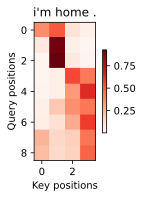

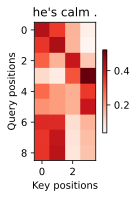

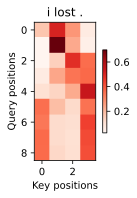

In [ ]:
# Sanity check for the attention implementation
for i in range(1, 4):
# predict on sample [-1] (last sample)
  _, dec_attention_weights = model.predict_step(
      data.build([engs[-i]], [fras[-i]]), d2l.try_gpu(), data.num_steps, True)
  attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
  attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))
  # Plus one to include the end-of-sequence token

  d2l.show_heatmaps(
      attention_weights[:, :, :, :len(engs[-i].split()) + 1].cpu(),
      xlabel='Key positions', ylabel='Query positions', titles=[engs[-i]])

Looking at the attention maps we can see they are different, but we can still see the importence of the order, for instance in the sentence "he's calm." we can really see a diagonal of the most important words, which make every tranlated word focus on the equivalent word.

# Helper Functions

Attached are two functions that were used from the `d2l` library.
They are provided for anyone that seeks further clarification of their preformance.

In [ ]:
class MTFraEng(d2l.DataModule):
  """The English-French dataset"""
  def _download(self):
    d2l.extract(d2l.download(
      d2l.DATA_URL+'fra-eng.zip', self.root,
      '94646ad1522d915e7b0f9296181140edcf86a4f5'))
    with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
      return f.read()

  def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
          for i, char in enumerate(text.lower())]
    return ''.join(out)

  def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
      if max_examples and i > max_examples: break
      parts = line.split('\t')
      if len(parts) == 2:
        # Skip empty tokens
        src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
        tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

  def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
      self._download())

  def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
      pad_or_trim = lambda seq, t: (
        seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
      sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
      if is_tgt:
        sentences = [['<bos>'] + s for s in sentences]
      if vocab is None:
        vocab = d2l.Vocab(sentences, min_freq=2)
      array = d2l.tensor([vocab[s] for s in sentences])
      valid_len = d2l.reduce_sum(
        d2l.astype(array != vocab['<pad>'], d2l.int32), 1)
      return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text), self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]), src_vocab, tgt_vocab)

  def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

  def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
      src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
      raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

class Trainer(d2l.HyperParameters):
  """The base class for training models with data."""
  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    assert num_gpus == 0, 'No GPU support yet'

  def prepare_data(self, data):
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader)
                            if self.val_dataloader is not None else 0)

  def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    self.model = model

  def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()

  def fit_epoch(self):
    raise NotImplementedError

  def prepare_batch(self, batch):
    return batch

  def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
      loss = self.model.training_step(self.prepare_batch(batch))
      self.optim.zero_grad()
      with torch.no_grad():
        loss.backward()
        if self.gradient_clip_val > 0:  # To be discussed later
          self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step()
      self.train_batch_idx += 1
    if self.val_dataloader is None:
      return
    self.model.eval()
    for batch in self.val_dataloader:
      with torch.no_grad():
        self.model.validation_step(self.prepare_batch(batch))
      self.val_batch_idx += 1

  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

  def prepare_batch(self, batch):
    if self.gpus:
      batch = [d2l.to(a, self.gpus[0]) for a in batch]
    return batch

  def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
      model.to(self.gpus[0])
    self.model = model

  def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
      for param in params:
        param.grad[:] *= grad_clip_val / norm
